### Cap 1

#### Introdução e Contextualização

O dataset escolhido para este trabalho é o [Global Coffee Health Dataset](https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset).

O café é uma das bebidas mais consumidas globalmente, com profundo impacto econômico, cultural e na saúde pública. Estudos recentes demonstram que o consumo moderado de café está associado a benefícios significativos para a saúde, incluindo redução do risco de mortalidade por todas as causas, doenças cardiovasculares, certos tipos de câncer e condições metabólicas e hepáticas . No entanto, esses efeitos podem variar conforme fatores como genética, métodos de preparo e hábitos de consumo.

O Global Coffee Health Dataset, disponibilizado publicamente no Kaggle, foi criado para agregar dados heterogêneos relacionados ao consumo de café e seus efeitos na saúde. Este dataset permite análises padronizadas e a aplicação de técnicas de aprendizado de máquina para identificar padrões complexos entre variáveis socioculturais, comportamentais e clínicas.

#### Descrição do Dataset

O dataset escolhido é do tipo tabular, consistindo de um total de 10000 amostras. Cada amostra é composta por dados referentes à indivíduos participantes na pesquisa desenvolvida para compor o dataset. Os atributos disponíveis são:

|Nome do atributo|Tipo de dado|Descrição|
|---|---|---|
|ID|Inteiro|Identificador único para cada amostra.|
|Age|Inteiro|Idade dos participantes.|
|Gender|Categórico|O gênero dos participantes.|
|Country|Categórico|País de residência dos participantes.|	
|Coffee_Intake|Numérico|Copos de café consumidos diariamente.|
|Caffeine_mg|Numérico|Consumo estimado em mg de cafeína (considerando 1 copo = 95mg).|
|Sleep_Hours|Numérico|Média de horas de sono por noite.|
|Sleep_Quality|Categórico|Indicador da qualidade do sono (baseado em Sleep_Hours).|
|BMI|Numérico|O índice de massa corporal dos participantes.|
|Heart_Rate|Inteiro|Batimentos cardíacos em repouso.|
|Stress_Level|Categórico|Indicador do nível de estresse.|
|Physical_Activity_Hours|Numérico|Horas de atividade física por semana.|
|Health_Issues|Categórico|Indicador do grau de problemas de saúde dos participantes.|
|Occupation|Categórico|Profissão dos participantes.|
|Smoking|Booleano|Indicador se os participantes fumam (1) ou não (0).|
|Alcohol_Consumption|Booleano|Indicador se os participantes consomen álcool (1) ou não (0).|

Para este trabalho, a coluna `Health_Issues` será tratada como a coluna classificadora, sendo seus valores (None, Mild, Moderate, Severe) as classes.


### Cap 2  

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import mahalanobis
import numpy as np
from numpy.linalg import inv

In [49]:
df = pd.read_csv('../synthetic_coffee_health_10000.csv')

df['Health_Issues'] = df['Health_Issues'].fillna('None')

# 2.1 Espaço amostral
total_dataset_samples = len(df)
classes = df['Health_Issues'].unique()

print(f"Total samples in Dataset: {total_dataset_samples}")
print(f"Different Classes in Dataset: {classes}")

Total samples in Dataset: 10000
Different Classes in Dataset: ['None' 'Mild' 'Moderate' 'Severe']


In [50]:
# 2.2 Probabilidades dos resultados possíveis

none_samples = df['Health_Issues'].value_counts()['None']
mild_samples = df['Health_Issues'].value_counts()['Mild']
moderate_samples = df['Health_Issues'].value_counts()['Moderate']
severe_samples = df['Health_Issues'].value_counts()['Severe']

print(f"Total None Health Issues samples: {none_samples}")
print(f"Total Mild Health Issues samples: {mild_samples}")
print(f"Total Moderate Health Issues samples: {moderate_samples}")
print(f"Total Severe Health Issues samples: {severe_samples}\n")

prob_None = none_samples / total_dataset_samples
prob_Mild = mild_samples / total_dataset_samples
prob_Moderate = moderate_samples / total_dataset_samples
prob_Severe = severe_samples / total_dataset_samples

print(f"Probability of None Health Issues: {prob_None}")
print(f"Probability of Mild Health Issues: {prob_Mild}")
print(f"Probability of Moderate Health Issues: {prob_Moderate}")
print(f"Probability of Severe Health Issues: {prob_Severe}")

Total None Health Issues samples: 5941
Total Mild Health Issues samples: 3579
Total Moderate Health Issues samples: 463
Total Severe Health Issues samples: 17

Probability of None Health Issues: 0.5941
Probability of Mild Health Issues: 0.3579
Probability of Moderate Health Issues: 0.0463
Probability of Severe Health Issues: 0.0017


In [51]:
# 2.3 Definição de 3 eventos e suas probabilidades
# Evento 1 - Participantes que bebem
# Evento 2 - Participantes que fumam
# Evento 3 - Participantes que não dormem bem (Sleep_Quality = Poor)

c_event1 = df['Alcohol_Consumption'].value_counts()[1]
c_event2 = df['Smoking'].value_counts()[1]
c_event3 = df['Sleep_Quality'].value_counts()['Poor']

print(f"Total Drinking samples: {c_event1}")
print(f"Total Smoking samples: {c_event2}")
print(f"Total Poor Sleep samples: {c_event3}")

prob_event1 = c_event1 / total_dataset_samples
prob_event2 = c_event2 / total_dataset_samples
prob_event3 = c_event3 / total_dataset_samples

print(f"Probability of Event 1: {prob_event1}")
print(f"Probability of Event 2: {prob_event2}")
print(f"Probability of Event 3: {prob_event3}")

Total Drinking samples: 3007
Total Smoking samples: 2004
Total Poor Sleep samples: 961
Probability of Event 1: 0.3007
Probability of Event 2: 0.2004
Probability of Event 3: 0.0961


In [52]:
# 2.4 Descrever/Comente como a escolha das características (eventos) diferentes modificaram (ou não) os resultados
events = {
    "Event 1": df['Alcohol_Consumption'] == 1,
    "Event 2": df['Smoking'] == 1,
    "Event 3": df['Sleep_Quality'] == 'Poor'
}

conditional_probs = {}
for event_name, condition in events.items():
    event_data = df[condition]
    total_event = len(event_data)
    cond_probs = []
    for cls in classes:
        count_cls = len(event_data[event_data['Health_Issues'] == cls])
        cond_prob = count_cls / total_event
        cond_probs.append(cond_prob)
    conditional_probs[event_name] = cond_probs

# Comparação com probabilidades a priori
prior_probs = [prob_None, prob_Mild, prob_Moderate, prob_Severe]

for event_name, cond_probs in conditional_probs.items():
    print(f"\n{event_name}:")
    for cls, prior, cond in zip(classes, prior_probs, cond_probs):
        ratio = cond / prior
        print(f"  {cls}: Prior = {prior:.4f}, Condicional = {cond:.4f}, Ratio = {ratio:.2f}")


Event 1:
  None: Prior = 0.5941, Condicional = 0.6019, Ratio = 1.01
  Mild: Prior = 0.3579, Condicional = 0.3528, Ratio = 0.99
  Moderate: Prior = 0.0463, Condicional = 0.0442, Ratio = 0.96
  Severe: Prior = 0.0017, Condicional = 0.0010, Ratio = 0.59

Event 2:
  None: Prior = 0.5941, Condicional = 0.6018, Ratio = 1.01
  Mild: Prior = 0.3579, Condicional = 0.3433, Ratio = 0.96
  Moderate: Prior = 0.0463, Condicional = 0.0529, Ratio = 1.14
  Severe: Prior = 0.0017, Condicional = 0.0020, Ratio = 1.17

Event 3:
  None: Prior = 0.5941, Condicional = 0.0000, Ratio = 0.00
  Mild: Prior = 0.3579, Condicional = 0.8470, Ratio = 2.37
  Moderate: Prior = 0.0463, Condicional = 0.1498, Ratio = 3.24
  Severe: Prior = 0.0017, Condicional = 0.0031, Ratio = 1.84


In [53]:
# 2.5 União de probabilidades
prob_event1_or_event2 = len(df[(df['Alcohol_Consumption'] == 1) | (df['Smoking'] == 1)]) / total_dataset_samples
prob_event1_or_event3 = len(df[(df['Alcohol_Consumption'] == 1) | (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples
prob_event2_or_event3 = len(df[(df['Smoking'] == 1) | (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples

print(f"P(Event1 ∪ Event2): {prob_event1_or_event2}")
print(f"P(Event1 ∪ Event3): {prob_event1_or_event3}")
print(f"P(Event2 ∪ Event3): {prob_event2_or_event3}")

P(Event1 ∪ Event2): 0.443
P(Event1 ∪ Event3): 0.3678
P(Event2 ∪ Event3): 0.2788


In [54]:
# 2.6 Interseção de probabilidades
prob_event1_and_event2 = len(df[(df['Alcohol_Consumption'] == 1) & (df['Smoking'] == 1)]) / total_dataset_samples
prob_event1_and_event3 = len(df[(df['Alcohol_Consumption'] == 1) & (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples
prob_event2_and_event3 = len(df[(df['Smoking'] == 1) & (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples

print(f"P(Event1 ∩ Event2): {prob_event1_and_event2}")
print(f"P(Event1 ∩ Event3): {prob_event1_and_event3}")
print(f"P(Event2 ∩ Event3): {prob_event2_and_event3}")

P(Event1 ∩ Event2): 0.0581
P(Event1 ∩ Event3): 0.029
P(Event2 ∩ Event3): 0.0177


In [55]:
# 2.7 Defina 3 exemplos de probabilidades condicionais
# EventoC 1 - Problema de saúde dado que fuma
# EventoC 2 - Sem problema de saúde dado que sono excelente
# EventoC 3 - Problema de saúde dado que estresse alto ou pouca qualidade de sono

p_eventc1 = (
    len(df[(df['Smoking'] == 1) & (df['Health_Issues'] != 'None')]) / 
    len(df[df['Smoking'] == 1])
)
p_eventc2 = (
    len(df[(df['Sleep_Quality'] == 'Excellent') & (df['Health_Issues'] == 'None')]) /
    len(df[df['Sleep_Quality'] == 'Excellent'])
)

p_eventc3 = (
    len(df[((df['Stress_Level'] == 'High') | (df['Sleep_Quality'] == 'Poor')) & (df['Health_Issues'] != 'None')]) /
    len(df[(df['Stress_Level'] == 'High') | (df['Sleep_Quality'] == 'Poor')])
)

print(f"P(EventC1): {p_eventc1}")
print(f"P(EventC2): {p_eventc2}")
print(f"P(EventC3): {p_eventc3}")


P(EventC1): 0.39820359281437123
P(EventC2): 0.8357988165680473
P(EventC3): 1.0


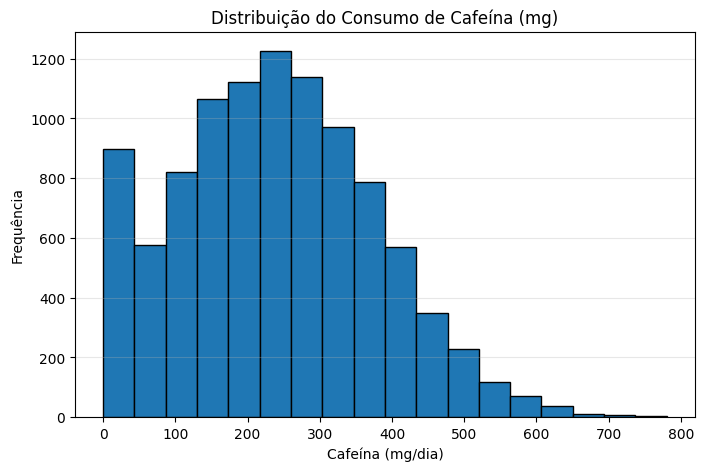

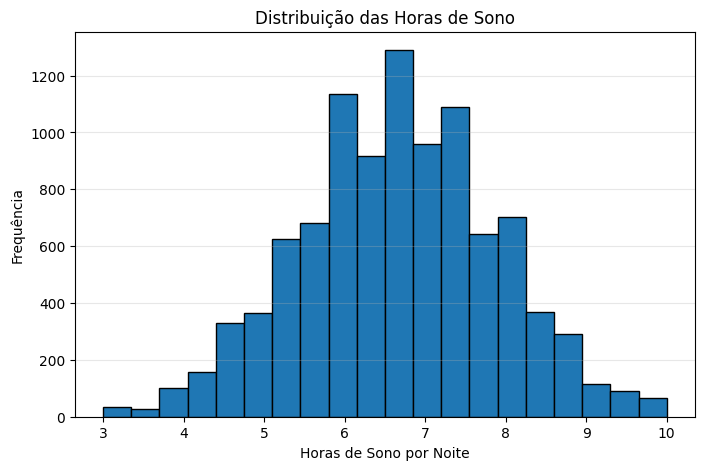

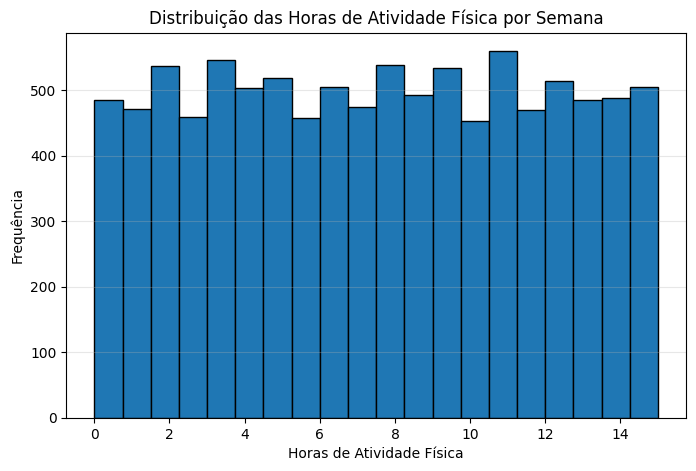

C:\Users\Walmir\AppData\Local\Temp\ipykernel_13800\84779481.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ordered_data, labels=class_order)


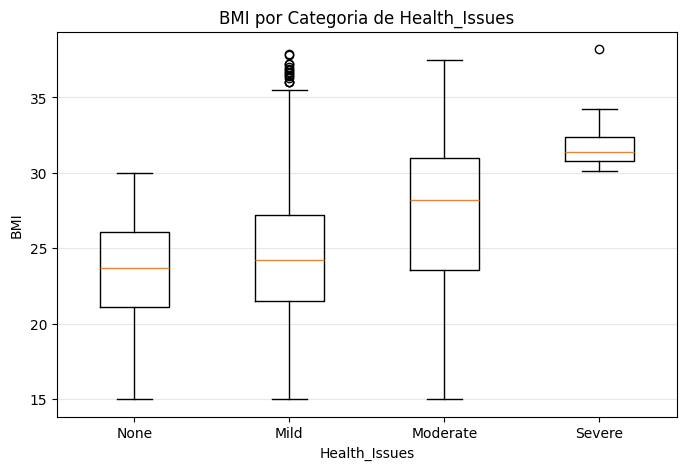

C:\Users\Walmir\AppData\Local\Temp\ipykernel_13800\84779481.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ordered_data, labels=class_order)


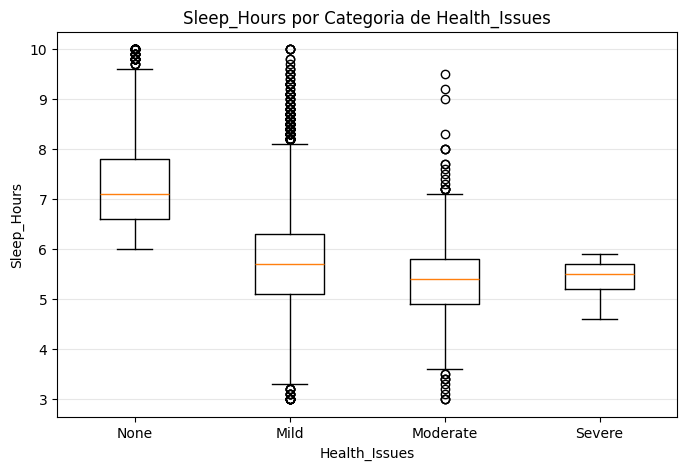

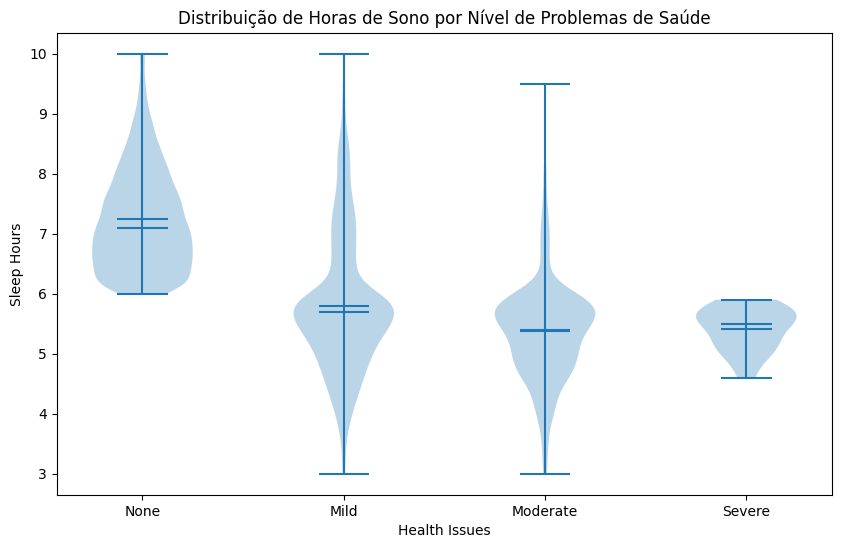

In [56]:
# --- Histogramas de partições ---
# Consumo de Cafeína (mg)
plt.figure(figsize=(8, 5))
plt.hist(df['Caffeine_mg'], bins=18, edgecolor='black')
plt.title('Distribuição do Consumo de Cafeína (mg)')
plt.xlabel('Cafeína (mg/dia)')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Horas de Sono
plt.figure(figsize=(8, 5))
plt.hist(df['Sleep_Hours'], bins=20, edgecolor='black')
plt.title('Distribuição das Horas de Sono')
plt.xlabel('Horas de Sono por Noite')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Atividade Física
plt.figure(figsize=(8, 5))
plt.hist(df['Physical_Activity_Hours'], bins=20, edgecolor='black')
plt.title('Distribuição das Horas de Atividade Física por Semana')
plt.xlabel('Horas de Atividade Física')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- Boxplots por classe de Health_Issues ---
features = ['BMI', 'Sleep_Hours']
class_order = ['None', 'Mild', 'Moderate', 'Severe']

for feature in features:
    plt.figure(figsize=(8, 5))
    ordered_data = [df[df['Health_Issues'] == cls][feature].dropna() for cls in class_order]
    plt.boxplot(ordered_data, labels=class_order)
    plt.title(f'{feature} por Categoria de Health_Issues')
    plt.xlabel('Health_Issues')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Supondo que df seja seu DataFrame
fig, ax = plt.subplots(figsize=(10, 6))
violin = ax.violinplot(
    [df[df['Health_Issues'] == cat]['Sleep_Hours'] for cat in ['None', 'Mild', 'Moderate', 'Severe']],
    showmeans=True,
    showmedians=True
)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['None', 'Mild', 'Moderate', 'Severe'])
ax.set_xlabel('Health Issues')
ax.set_ylabel('Sleep Hours')
ax.set_title('Distribuição de Horas de Sono por Nível de Problemas de Saúde')
plt.show()

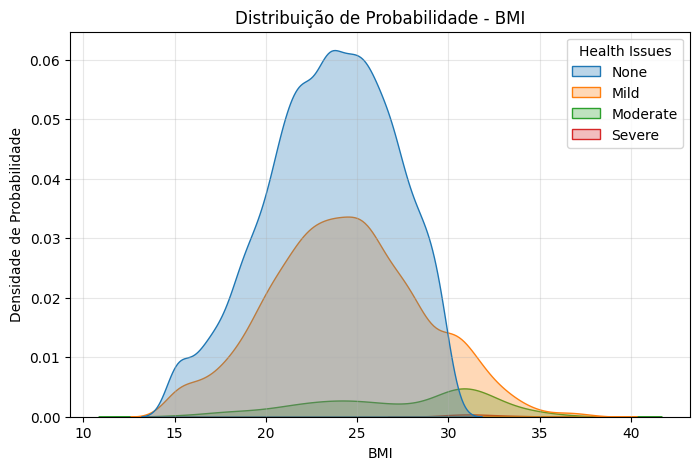

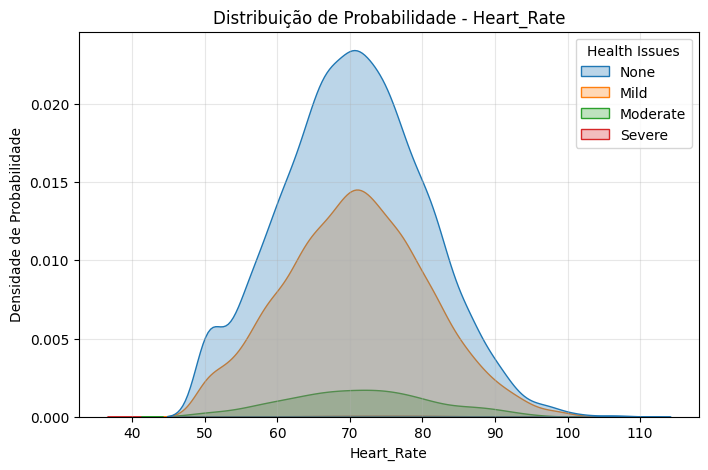

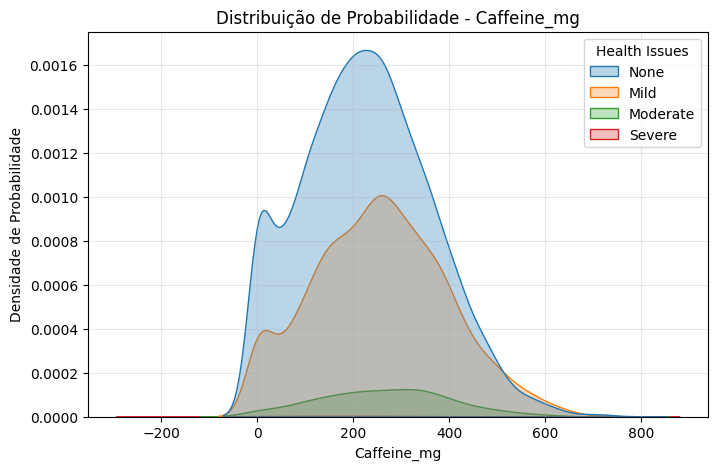

In [57]:
# 2.9 Aplicar FDP
features = ['BMI', 'Heart_Rate', 'Caffeine_mg']

for feature in features:
    plt.figure(figsize=(8, 5))
    
    ax = sns.kdeplot(data=df, x=feature, hue='Health_Issues', fill=True, alpha=0.3)
    
    plt.title(f'Distribuição de Probabilidade - {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densidade de Probabilidade')
    
    if ax.get_legend():
        ax.get_legend().set_title('Health Issues')
    
    plt.grid(alpha=0.3)
    plt.show()

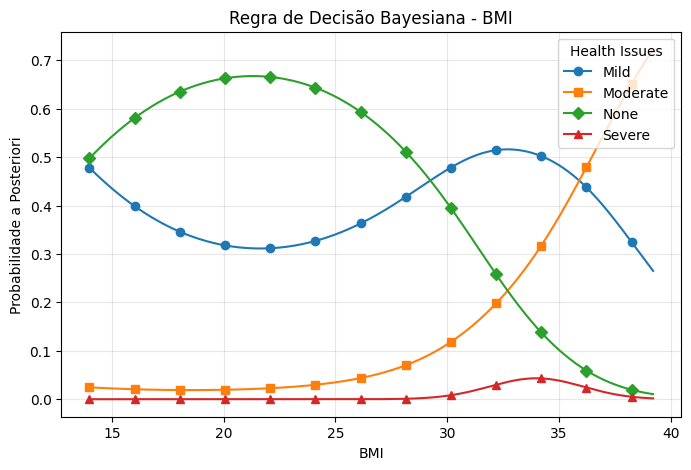

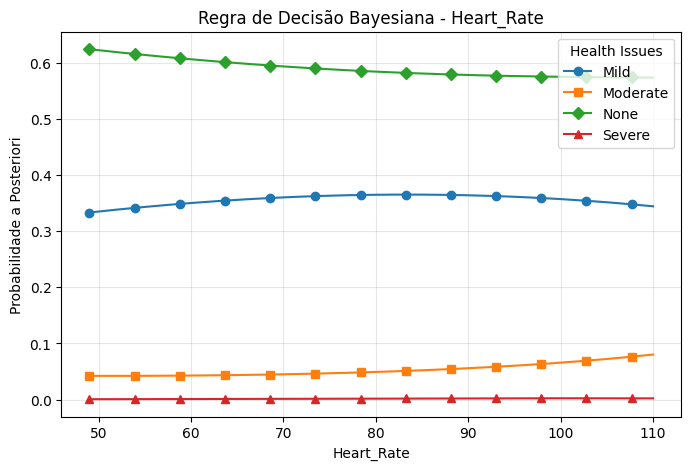

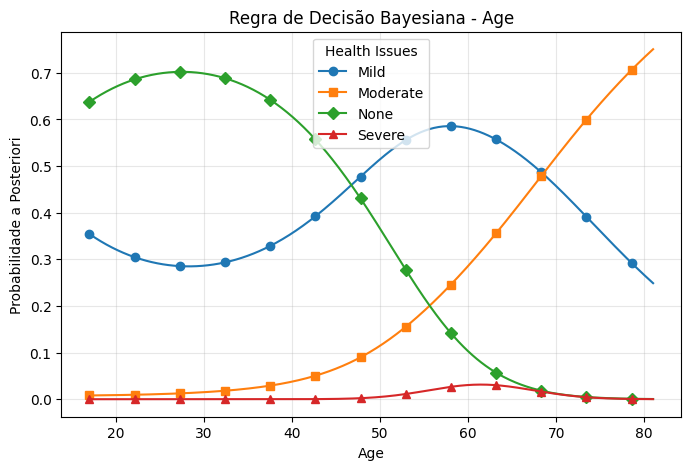

In [58]:
# 2.10 Aplicar Bayes

# Features numéricas escolhidas para aplicar Bayes
features = ['BMI', 'Heart_Rate', 'Age']

# Marcadores para diferenciar as classes
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

# Aplicar regra de decisão Bayesiana para cada feature
for feature in features:
    x = df[[feature]].values
    y = df['Health_Issues'].values

    model = GaussianNB()
    model.fit(x, y)

    x_min, x_max = x.min() - 1, x.max() + 1
    x_vals = np.linspace(x_min, x_max, 500).reshape(-1, 1)

    # Probabilidades a posteriori
    posterior_probs = model.predict_proba(x_vals)

    plt.figure(figsize=(8, 5))
    for i, cls in enumerate(model.classes_):
        marker = markers[i % len(markers)]
        plt.plot(x_vals, posterior_probs[:, i], label=cls, marker=marker, markevery=40)

    plt.title(f'Regra de Decisão Bayesiana - {feature}')
    plt.xlabel(feature)
    plt.ylabel('Probabilidade a Posteriori')
    plt.legend(title='Health Issues')
    plt.grid(alpha=0.3)
    plt.show()


### Cap 3

In [59]:
# 3 Seleção de Características para Aprendizado Não Supervisionado

# Características escolhidas
features = ["BMI", "Sleep_Hours", "Caffeine_mg", "Age", "Sleep_Quality"]

sleep_quality_map = {
    "Poor": 1,
    "Fair": 2,
    "Good": 3,
    "Excellent": 4
}

df["Sleep_Quality"] = df["Sleep_Quality"].map(sleep_quality_map)


X = df[features].dropna()

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print(X_scaled_df.head())

# Definir ordem desejada ANTES de calcular true_labels
ordem_desejada = ['None', 'Mild', 'Moderate', 'Severe']
mapeamento_manual = {
    'None': 0,
    'Mild': 1, 
    'Moderate': 2,
    'Severe': 3
}

# Aplicar mapeamento
true_labels = df.loc[X_scaled_df.index, "Health_Issues"].map(mapeamento_manual).values

# Criar LabelEncoder para consistência (se necessário para outras partes)
le = LabelEncoder()
le.classes_ = np.array(ordem_desejada)
# ====== ATÉ AQUI ======

# Agora continue com o código original...
print("=== MAPEAMENTO DOS RÓTULOS ===")
for valor, rotulo in enumerate(ordem_desejada):
    print(f"  Valor {valor}: {rotulo}")
print()


        BMI  Sleep_Hours  Caffeine_mg       Age  Sleep_Quality
0  0.233766     0.706861     0.651138  0.452574       0.323492
1 -1.020645    -0.356974    -1.047691 -0.174645       0.323492
2 -0.329439    -0.602474     1.925986  0.631779      -0.911211
3  0.182565     0.543194     0.078328  1.617409       0.323492
4  0.028964    -1.093475     0.432613 -0.264247      -0.911211
=== MAPEAMENTO DOS RÓTULOS ===
  Valor 0: None
  Valor 1: Mild
  Valor 2: Moderate
  Valor 3: Severe



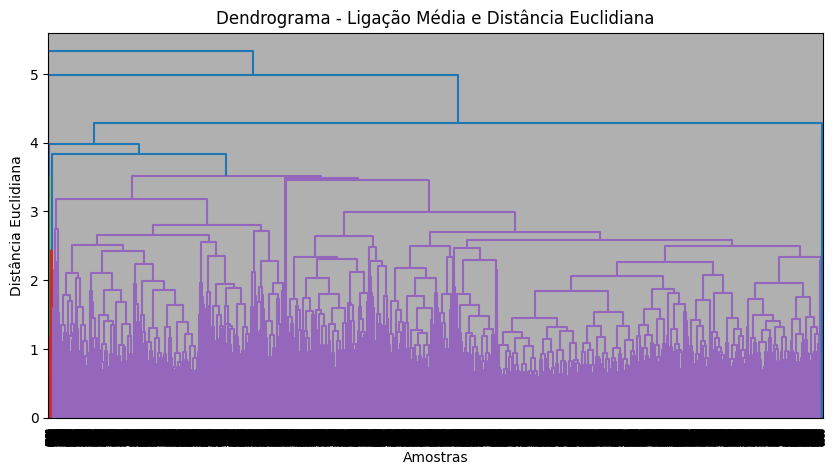

[Euclidiana] Média intra-cluster: 2.093
[Euclidiana] Média inter-cluster: 5.248
[Euclidiana] Pureza: 0.595


In [60]:
# 3.1 Ligação Média e Distância Euclidiana

Z_euclidean = linkage(X_scaled, method='average', metric='euclidean')

plt.figure(figsize=(10, 5))
dendrogram(Z_euclidean)
plt.title("Dendrograma - Ligação Média e Distância Euclidiana")
plt.xlabel("Amostras")
plt.ylabel("Distância Euclidiana")
plt.grid(True)
plt.show()

# --- Avaliação quantitativa dos clusters ---
n_clusters = 4
clusters = fcluster(Z_euclidean, n_clusters, criterion='maxclust')

# Matriz de distâncias
D = pairwise_distances(X_scaled, metric='euclidean')

# Intra-cluster
intra_dists = []
for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    if len(idx) > 1:
        intra_dists.append(D[np.ix_(idx, idx)].mean())
intra_mean = np.mean(intra_dists)

# Inter-cluster
centroids = np.array([X_scaled[clusters == c].mean(axis=0) for c in np.unique(clusters)])
D_centroids = pairwise_distances(centroids, metric='euclidean')
inter_mean = D_centroids[np.triu_indices_from(D_centroids, k=1)].mean()

# Pureza
le = LabelEncoder()
true_labels = le.fit_transform(df.loc[X_scaled_df.index, "Health_Issues"])
contingency = pd.crosstab(clusters, true_labels)
purity = np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

print(f"[Euclidiana] Média intra-cluster: {intra_mean:.3f}")
print(f"[Euclidiana] Média inter-cluster: {inter_mean:.3f}")
print(f"[Euclidiana] Pureza: {purity:.3f}")

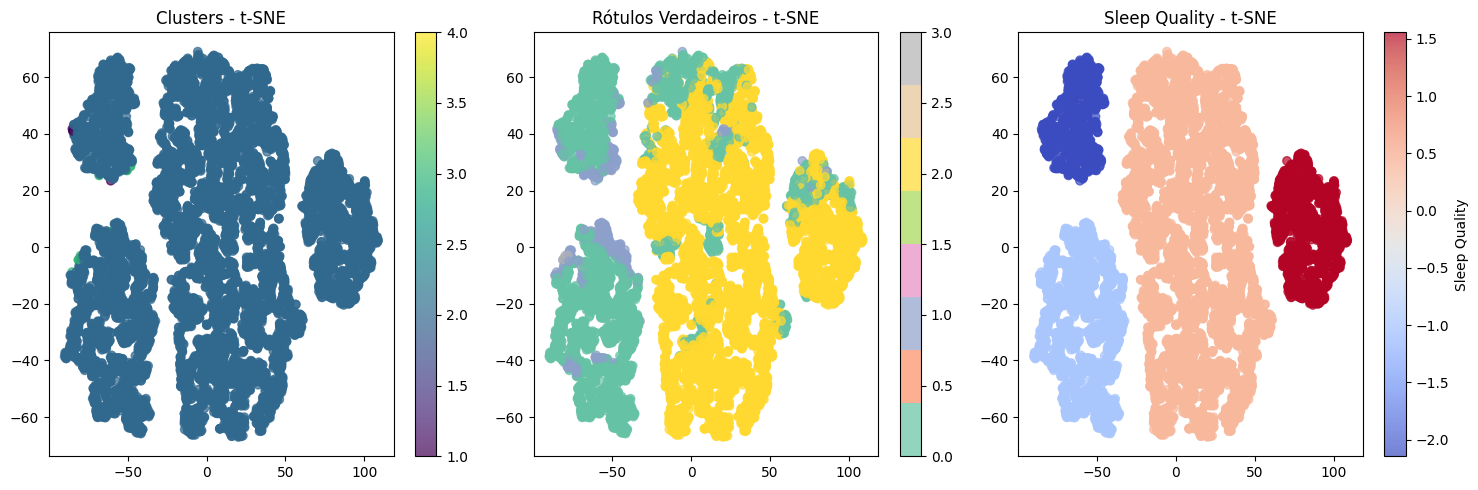

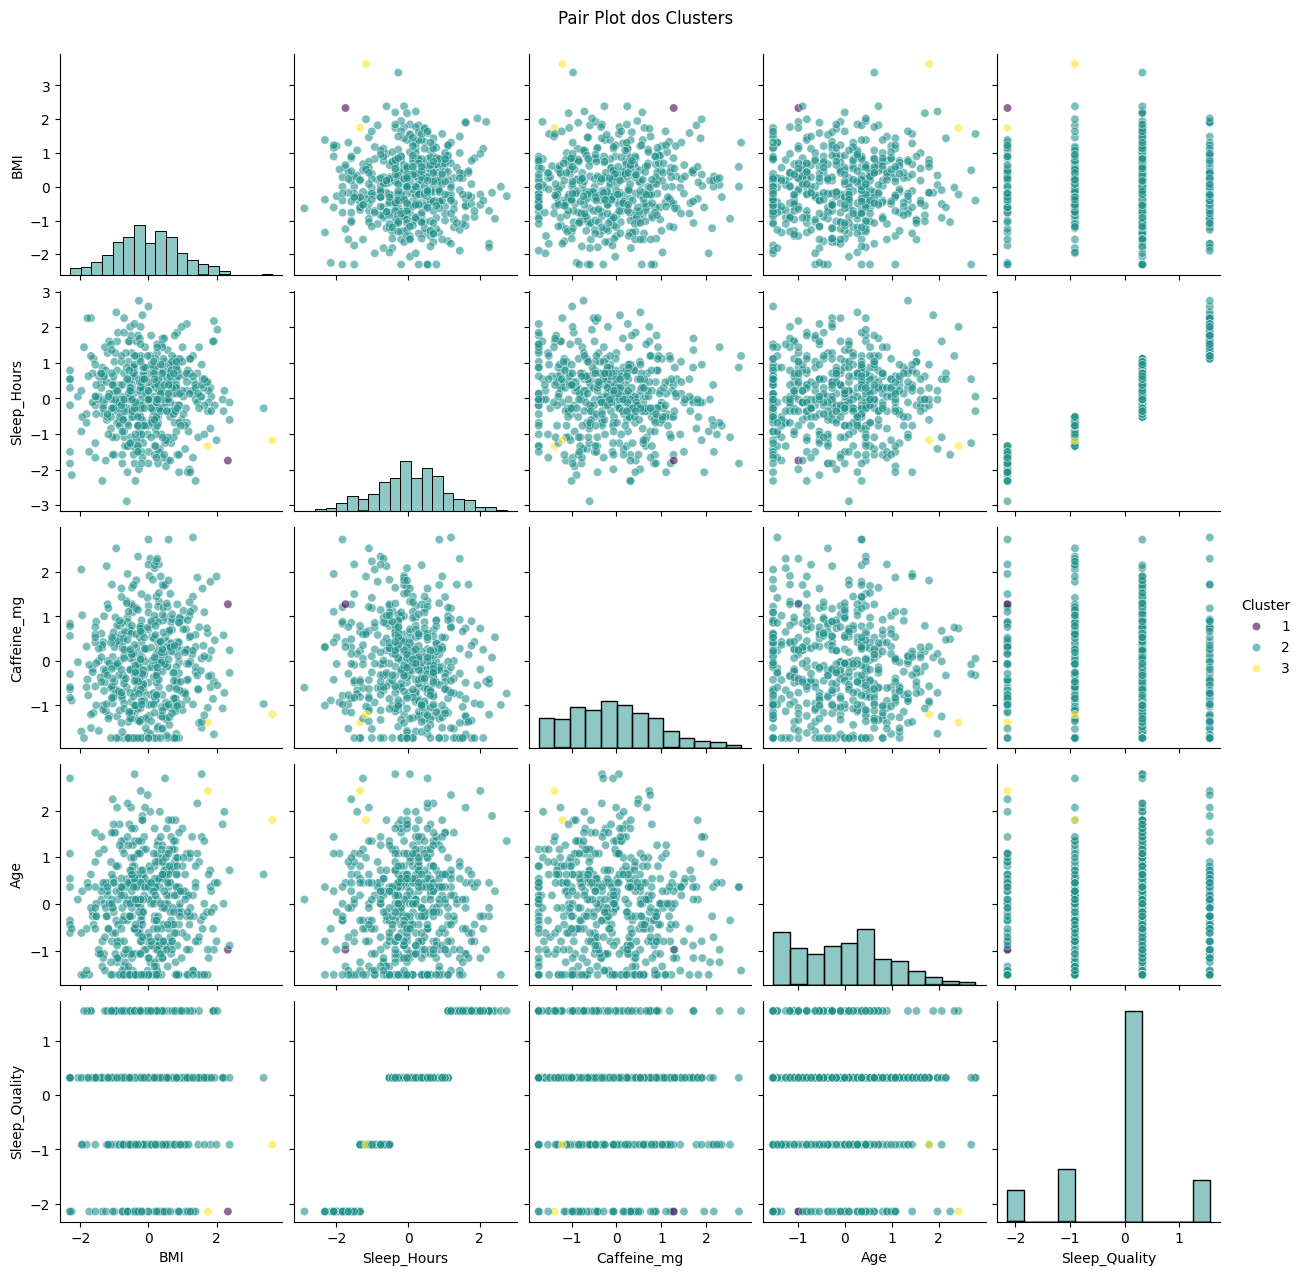

In [61]:
# Adicionar clusters ao DataFrame original
df_clustered = X_scaled_df.copy()
df_clustered['Cluster'] = clusters
df_clustered['Health_Issues'] = df.loc[X_scaled_df.index, 'Health_Issues']

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Plotar
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Clusters - t-SNE')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_labels, cmap='Set2', alpha=0.7)
plt.title('Rótulos Verdadeiros - t-SNE')
plt.colorbar()

plt.subplot(1, 3, 3)
# Colorir por Sleep_Quality para ver padrões
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_scaled_df['Sleep_Quality'], cmap='coolwarm', alpha=0.7)
plt.title('Sleep Quality - t-SNE')
plt.colorbar(label='Sleep Quality')

plt.tight_layout()
plt.show()

# Pair plot para visualizar relações entre variáveis
sample_df = df_clustered.copy()
# Se tiver muitos dados, amostrar para visualização
if len(sample_df) > 500:
    sample_df = sample_df.sample(500, random_state=42)

sns.pairplot(sample_df, vars=features, hue='Cluster', palette='viridis', 
             diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot dos Clusters', y=1.02)
plt.show()

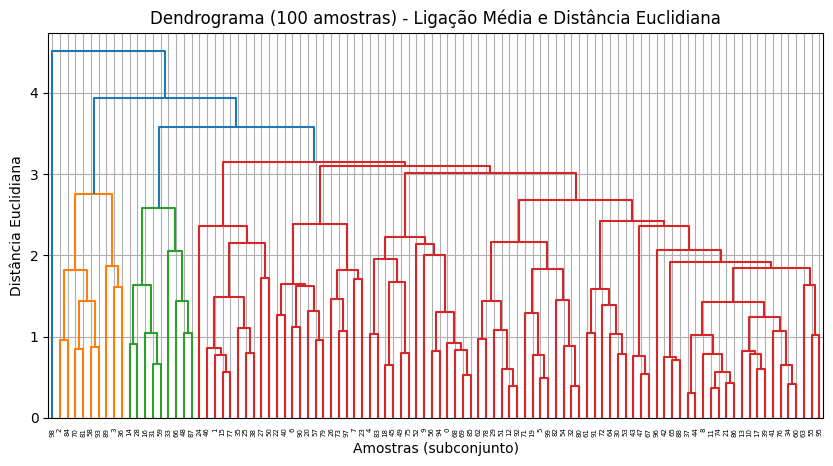

[Amostra - Euclidiana] Média intra-cluster: 2.169
[Amostra - Euclidiana] Média inter-cluster: 4.173
[Amostra - Euclidiana] Pureza: 0.650


In [62]:
sample_idx = np.random.choice(X_scaled.shape[0], size=100, replace=False)
X_sample = X_scaled[sample_idx]

Z_sample = linkage(X_sample, method='average', metric='euclidean')

plt.figure(figsize=(10, 5))
dendrogram(Z_sample)
plt.title("Dendrograma (100 amostras) - Ligação Média e Distância Euclidiana")
plt.xlabel("Amostras (subconjunto)")
plt.ylabel("Distância Euclidiana")
plt.grid(True)
plt.show()

n_clusters = 4
clusters = fcluster(Z_sample, n_clusters, criterion='maxclust')

D = pairwise_distances(X_sample, metric='euclidean')
intra_dists = []
for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    if len(idx) > 1:
        intra_dists.append(D[np.ix_(idx, idx)].mean())
intra_mean = np.mean(intra_dists)

centroids = np.array([X_sample[clusters == c].mean(axis=0) for c in np.unique(clusters)])
D_centroids = pairwise_distances(centroids, metric='euclidean')
inter_mean = D_centroids[np.triu_indices_from(D_centroids, k=1)].mean()

true_labels_sample = le.transform(df.loc[X_scaled_df.index[sample_idx], "Health_Issues"])
contingency = pd.crosstab(clusters, true_labels_sample)
purity = np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

print(f"[Amostra - Euclidiana] Média intra-cluster: {intra_mean:.3f}")
print(f"[Amostra - Euclidiana] Média inter-cluster: {inter_mean:.3f}")
print(f"[Amostra - Euclidiana] Pureza: {purity:.3f}")

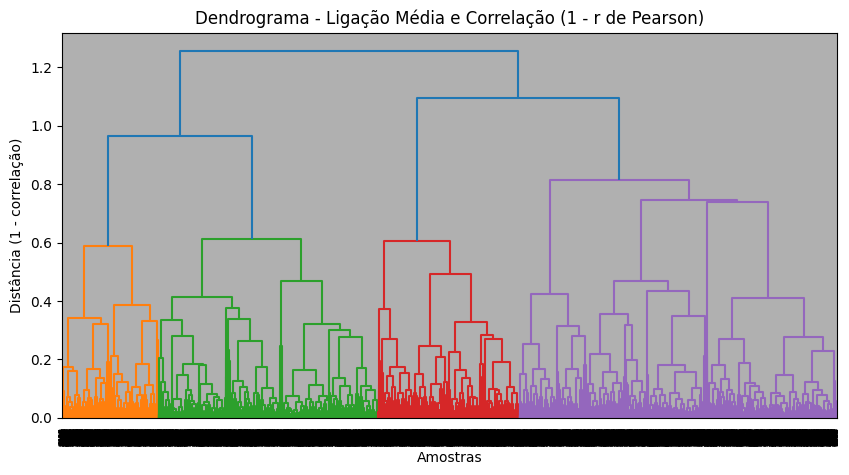

[Correlação] Média intra-cluster: 0.479
[Correlação] Média inter-cluster: 1.299
[Correlação] Pureza: 0.768


In [63]:
# 3.2 Ligação Média e Correlação

corr_dist = pdist(X_scaled, metric='correlation')

Z_corr = linkage(corr_dist, method='average')

plt.figure(figsize=(10, 5))
dendrogram(Z_corr)
plt.title("Dendrograma - Ligação Média e Correlação (1 - r de Pearson)")
plt.xlabel("Amostras")
plt.ylabel("Distância (1 - correlação)")
plt.grid(True)
plt.show()

# --- Avaliação quantitativa ---
n_clusters = 4
clusters = fcluster(Z_corr, n_clusters, criterion='maxclust')

D = pairwise_distances(X_scaled, metric='correlation')

# Intra cluster
intra_dists = []
for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    if len(idx) > 1:
        intra_dists.append(D[np.ix_(idx, idx)].mean())
intra_mean = np.mean(intra_dists)

# Inter cluster
centroids = np.array([X_scaled[clusters == c].mean(axis=0) for c in np.unique(clusters)])
D_centroids = pairwise_distances(centroids, metric='correlation')
inter_mean = D_centroids[np.triu_indices_from(D_centroids, k=1)].mean()

# Pureza
true_labels = le.transform(df.loc[X_scaled_df.index, "Health_Issues"])
contingency = pd.crosstab(clusters, true_labels)
purity = np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

print(f"[Correlação] Média intra-cluster: {intra_mean:.3f}")
print(f"[Correlação] Média inter-cluster: {inter_mean:.3f}")
print(f"[Correlação] Pureza: {purity:.3f}")


=== MAPEAMENTO DOS RÓTULOS ===
Health_Issues (Original) → Valor numérico no gráfico
  'Mild' → 0
  'Moderate' → 1
  'None' → 2
  'Severe' → 3

Mapeamento completo:
  Valor 0: Mild
  Valor 1: Moderate
  Valor 2: None
  Valor 3: Severe



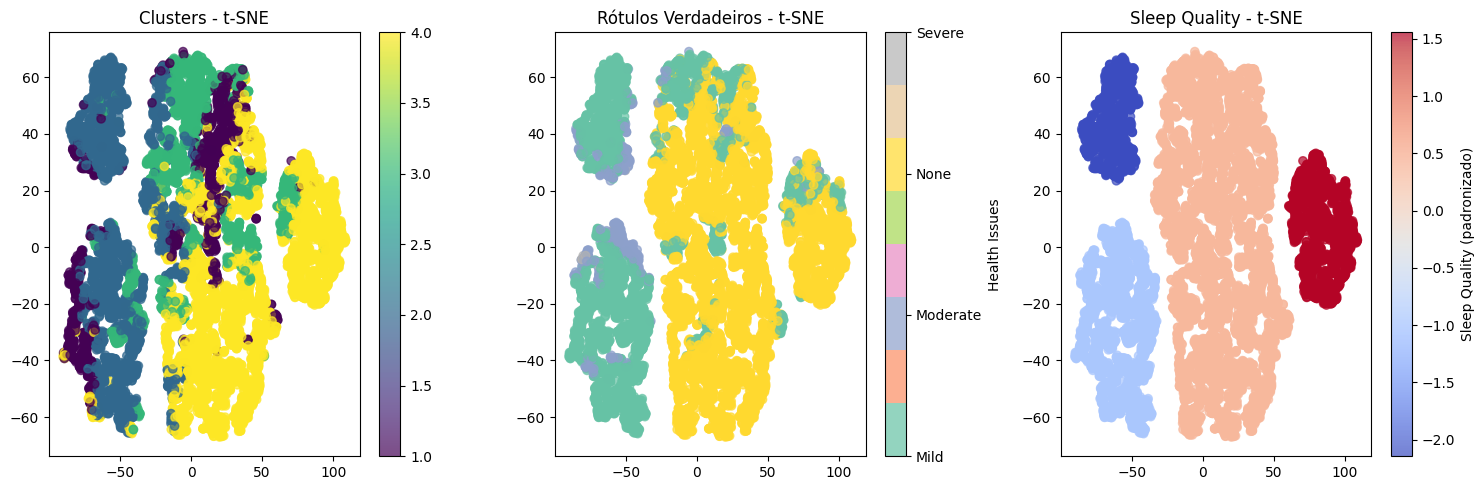

In [64]:
# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# ANTES dos plots, mostrar o mapeamento
print("=== MAPEAMENTO DOS RÓTULOS ===")
print("Health_Issues (Original) → Valor numérico no gráfico")
for i, class_name in enumerate(le.classes_):
    print(f"  '{class_name}' → {i}")
print()

# Ou em formato de dicionário
mapeamento = dict(zip(range(len(le.classes_)), le.classes_))
print("Mapeamento completo:")
for valor, rotulo in mapeamento.items():
    print(f"  Valor {valor}: {rotulo}")
print("=" * 50)
print()

# Plotar
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Clusters - t-SNE')
plt.colorbar()

plt.subplot(1, 3, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_labels, cmap='Set2', alpha=0.7)
plt.title('Rótulos Verdadeiros - t-SNE')
cbar = plt.colorbar(scatter)

# Adicionar labels na colorbar se tiver poucas classes
if len(le.classes_) <= 10:
    cbar.set_ticks(range(len(le.classes_)))
    cbar.set_ticklabels(le.classes_)
    cbar.set_label('Health Issues')

plt.subplot(1, 3, 3)
# Colorir por Sleep_Quality para ver padrões
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_scaled_df['Sleep_Quality'], cmap='coolwarm', alpha=0.7)
plt.title('Sleep Quality - t-SNE')
plt.colorbar(label='Sleep Quality (padronizado)')

plt.tight_layout()
plt.show()

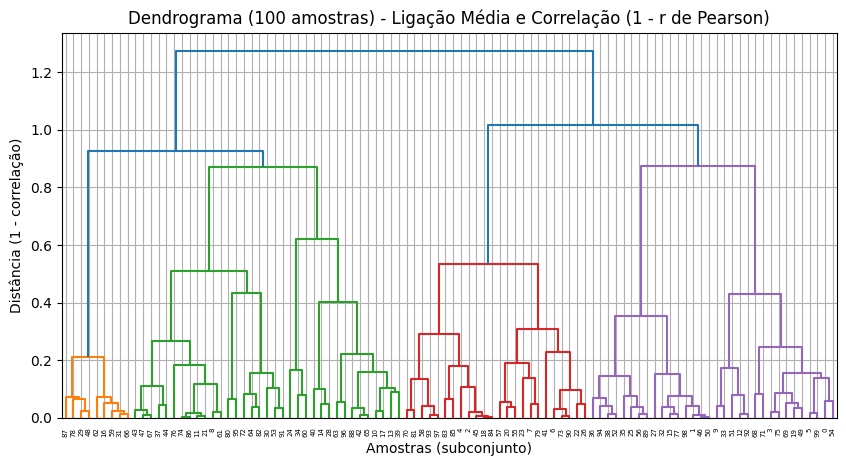

[Amostra - Correlação] Média intra-cluster: 0.413
[Amostra - Correlação] Média inter-cluster: 1.326
[Amostra - Correlação] Pureza: 0.740


In [65]:
corr_dist = pdist(X_sample, metric='correlation')
Z_corr_sample = linkage(corr_dist, method='average')

plt.figure(figsize=(10, 5))
dendrogram(Z_corr_sample)
plt.title("Dendrograma (100 amostras) - Ligação Média e Correlação (1 - r de Pearson)")
plt.xlabel("Amostras (subconjunto)")
plt.ylabel("Distância (1 - correlação)")
plt.grid(True)
plt.show()

n_clusters = 4
clusters = fcluster(Z_corr_sample, n_clusters, criterion='maxclust')

D = pairwise_distances(X_sample, metric='correlation')

intra_dists = []
for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    if len(idx) > 1:
        intra_dists.append(D[np.ix_(idx, idx)].mean())
intra_mean = np.mean(intra_dists)

centroids = np.array([X_sample[clusters == c].mean(axis=0) for c in np.unique(clusters)])
D_centroids = pairwise_distances(centroids, metric='correlation')
inter_mean = D_centroids[np.triu_indices_from(D_centroids, k=1)].mean()

true_labels_sample = le.transform(df.loc[X_scaled_df.index[sample_idx], "Health_Issues"])
contingency = pd.crosstab(clusters, true_labels_sample)
purity = np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

print(f"[Amostra - Correlação] Média intra-cluster: {intra_mean:.3f}")
print(f"[Amostra - Correlação] Média inter-cluster: {inter_mean:.3f}")
print(f"[Amostra - Correlação] Pureza: {purity:.3f}")

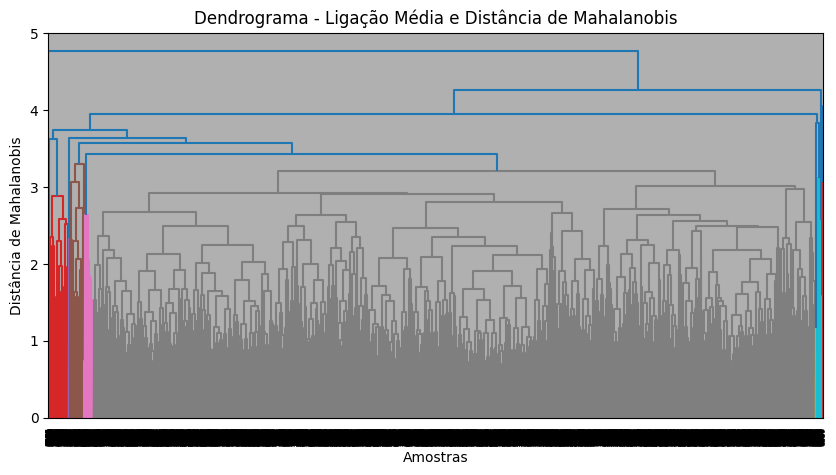

[Mahalanobis] Média intra-cluster: 2.393
[Mahalanobis] Média inter-cluster: 4.071
[Mahalanobis] Pureza: 0.595


In [66]:
# 3.3 Ligação Média e Distância de Mahalanobis

# Cálculo da matriz de covariância e sua inversa
VI = np.linalg.inv(np.cov(X_scaled, rowvar=False))

# Matriz de distâncias Mahalanobis
D_mahal = squareform(pdist(X_scaled, metric='mahalanobis', VI=VI))

Z_mahal = linkage(squareform(D_mahal, checks=False), method='average')

plt.figure(figsize=(10, 5))
dendrogram(Z_mahal)
plt.title("Dendrograma - Ligação Média e Distância de Mahalanobis")
plt.xlabel("Amostras")
plt.ylabel("Distância de Mahalanobis")
plt.grid(True)
plt.show()

# --- Avaliação quantitativa dos clusters ---
n_clusters = 4
clusters = fcluster(Z_mahal, n_clusters, criterion='maxclust')

# Intra-cluster
intra_dists = []
for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    if len(idx) > 1:
        intra_dists.append(D_mahal[np.ix_(idx, idx)].mean())
intra_mean = np.mean(intra_dists)

# Inter-cluster
centroids = np.array([X_scaled[clusters == c].mean(axis=0) for c in np.unique(clusters)])

# Distâncias Mahalanobis entre centróides
centroid_dists = []
for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):
        d = mahalanobis(centroids[i], centroids[j], VI)
        centroid_dists.append(d)
inter_mean = np.mean(centroid_dists)

# Pureza
le = LabelEncoder()
true_labels = le.fit_transform(df.loc[X_scaled_df.index, "Health_Issues"])
contingency = pd.crosstab(clusters, true_labels)
purity = np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

print(f"[Mahalanobis] Média intra-cluster: {intra_mean:.3f}")
print(f"[Mahalanobis] Média inter-cluster: {inter_mean:.3f}")
print(f"[Mahalanobis] Pureza: {purity:.3f}")


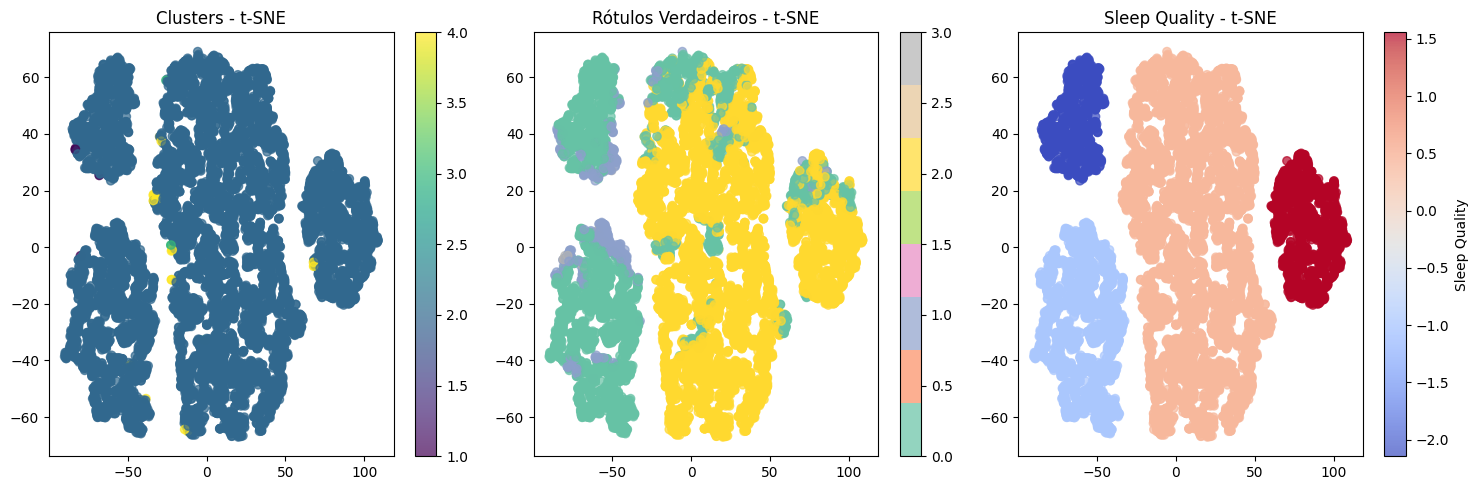

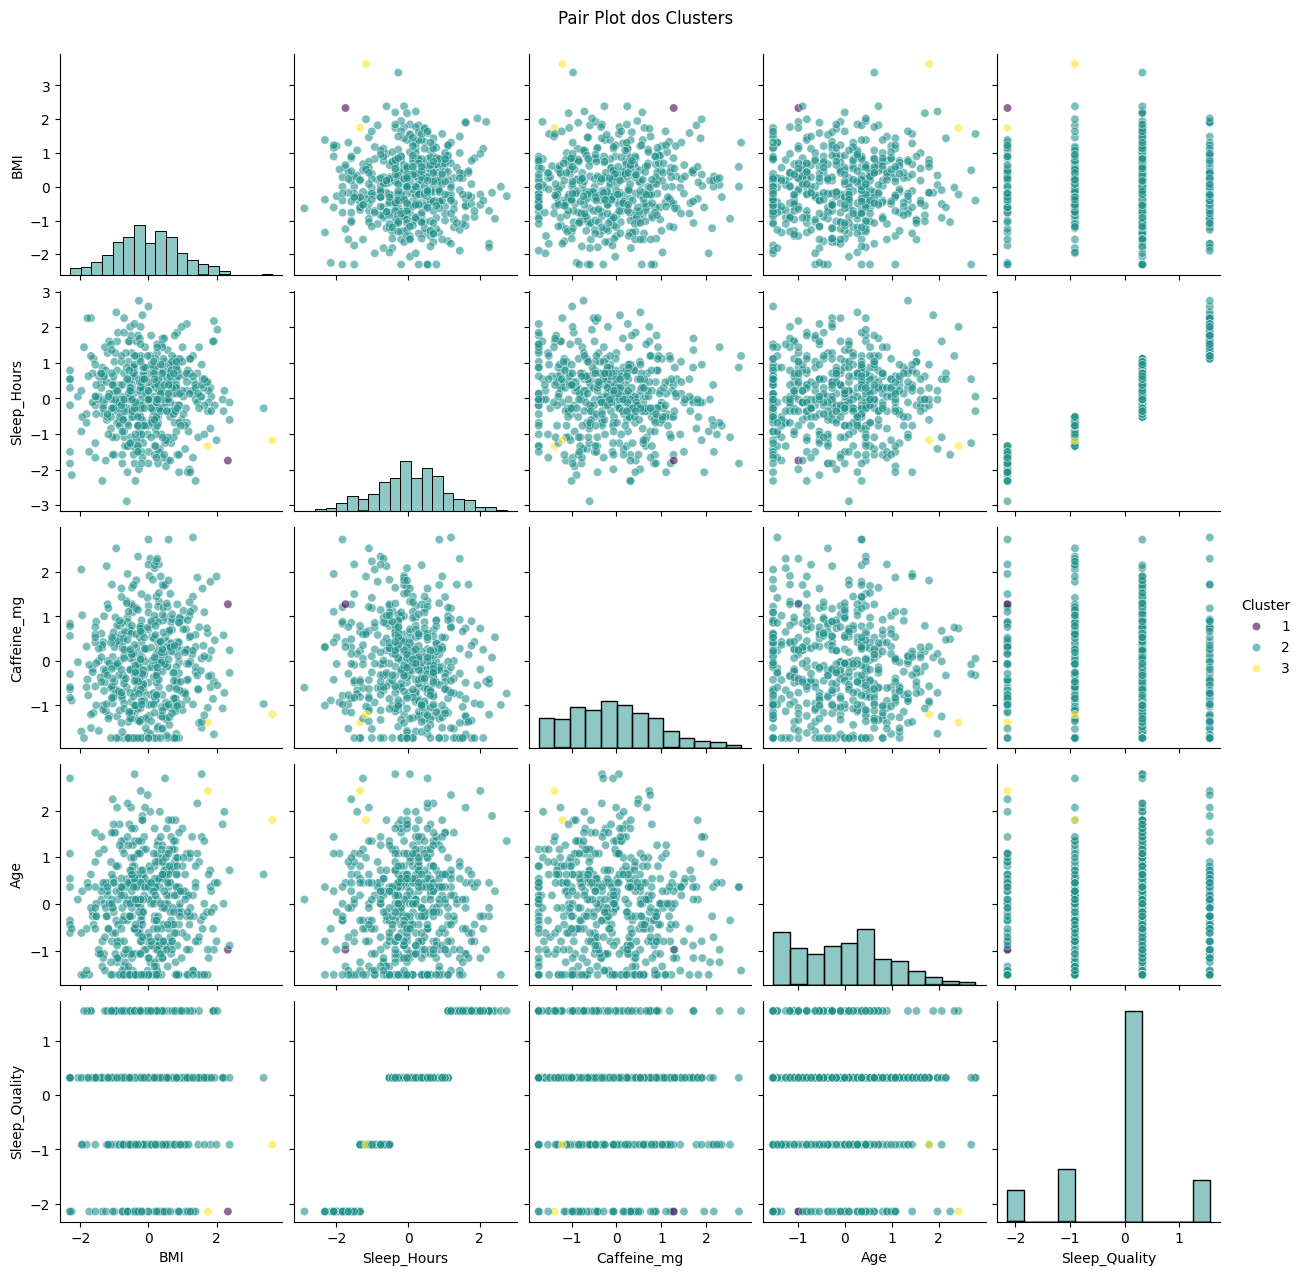

In [67]:
# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Plotar
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Clusters - t-SNE')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_labels, cmap='Set2', alpha=0.7)
plt.title('Rótulos Verdadeiros - t-SNE')
plt.colorbar()

plt.subplot(1, 3, 3)
# Colorir por Sleep_Quality para ver padrões
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_scaled_df['Sleep_Quality'], cmap='coolwarm', alpha=0.7)
plt.title('Sleep Quality - t-SNE')
plt.colorbar(label='Sleep Quality')

plt.tight_layout()
plt.show()

# Pair plot para visualizar relações entre variáveis
sample_df = df_clustered.copy()
# Se tiver muitos dados, amostrar para visualização
if len(sample_df) > 500:
    sample_df = sample_df.sample(500, random_state=42)

sns.pairplot(sample_df, vars=features, hue='Cluster', palette='viridis', 
             diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot dos Clusters', y=1.02)
plt.show()

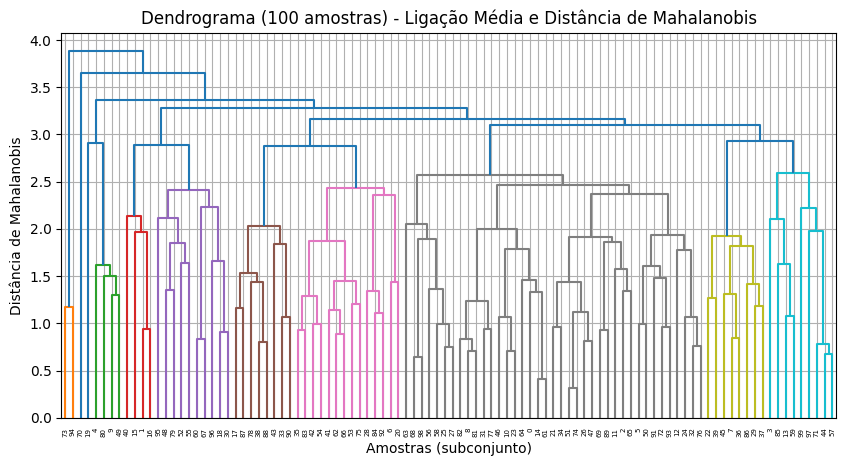

[Amostra - Mahalanobis] Média intra-cluster: 1.724
[Amostra - Mahalanobis] Média inter-cluster: 3.598
[Amostra - Mahalanobis] Pureza: 0.670


In [68]:
# 3.3 Ligação Média e Distância de Mahalanobis (100 amostras)

sample_idx = np.random.choice(X_scaled.shape[0], size=100, replace=False)
X_sample = X_scaled[sample_idx]

VI_sample = np.linalg.inv(np.cov(X_sample, rowvar=False))

D_mahal_sample = squareform(pdist(X_sample, metric='mahalanobis', VI=VI_sample))

Z_mahal_sample = linkage(squareform(D_mahal_sample, checks=False), method='average')

plt.figure(figsize=(10, 5))
dendrogram(Z_mahal_sample)
plt.title("Dendrograma (100 amostras) - Ligação Média e Distância de Mahalanobis")
plt.xlabel("Amostras (subconjunto)")
plt.ylabel("Distância de Mahalanobis")
plt.grid(True)
plt.show()

# --- Avaliação quantitativa dos clusters ---
n_clusters = 4
clusters = fcluster(Z_mahal_sample, n_clusters, criterion='maxclust')

# Intra-cluster
intra_dists = []
for c in np.unique(clusters):
    idx = np.where(clusters == c)[0]
    if len(idx) > 1:
        intra_dists.append(D_mahal_sample[np.ix_(idx, idx)].mean())
intra_mean = np.mean(intra_dists)

# Inter-cluster
centroids = np.array([X_sample[clusters == c].mean(axis=0) for c in np.unique(clusters)])

centroid_dists = []
for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):
        d = mahalanobis(centroids[i], centroids[j], VI_sample)
        centroid_dists.append(d)
inter_mean = np.mean(centroid_dists)

# Pureza
true_labels_sample = le.transform(df.loc[X_scaled_df.index[sample_idx], "Health_Issues"])
contingency = pd.crosstab(clusters, true_labels_sample)
purity = np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

print(f"[Amostra - Mahalanobis] Média intra-cluster: {intra_mean:.3f}")
print(f"[Amostra - Mahalanobis] Média inter-cluster: {inter_mean:.3f}")
print(f"[Amostra - Mahalanobis] Pureza: {purity:.3f}")


### Cap 4

In [122]:
# 4 Aprendizado Supervisionado

df_supervised = df.copy()

# Mapear variáveis categóricas
df_supervised['Gender'] = df_supervised['Gender'].map({'Male': 0, 'Female': 1, 'Other': 2})

country_encoder = LabelEncoder()
df_supervised['Country_encoded'] = country_encoder.fit_transform(df_supervised['Country'])

stress_map = {"Low": 1, "Medium": 2, "High": 3}
df_supervised["Stress_Level"] = df_supervised["Stress_Level"].map(stress_map)

occupation_encoder = LabelEncoder()
df_supervised['Occupation_encoded'] = occupation_encoder.fit_transform(df_supervised['Occupation'])

if df_supervised['Smoking'].dtype == 'object':
    df_supervised['Smoking'] = df_supervised['Smoking'].map({'No': 0, 'Yes': 1})

if df_supervised['Alcohol_Consumption'].dtype == 'object':
    df_supervised['Alcohol_Consumption'] = df_supervised['Alcohol_Consumption'].map({'No': 0, 'Yes': 1})

health_encoder = LabelEncoder()
df_supervised['Health_Issues_encoded'] = health_encoder.fit_transform(df_supervised['Health_Issues'])

all_features = [
    'Age', 'Gender', 'Country_encoded', 'Coffee_Intake', 
    'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 
    'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 
    'Occupation_encoded', 'Smoking', 'Alcohol_Consumption'
]

# Separar features e target
X = df_supervised[all_features]
y = df_supervised['Health_Issues_encoded']

In [123]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=all_features)

# Split 70/30 para treinamento/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=42, stratify=y
)

In [124]:
# Funções auxiliares para classificação
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    cm = confusion_matrix(y_test, y_pred)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return {
        'model': model,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=16)
    plt.ylabel('Classe Real', fontsize=14)
    plt.xlabel('Classe Predita', fontsize=14)
    plt.tight_layout()
    plt.show()

def print_evaluation_results(results, model_name, features_used=None):    
    if features_used:
        print(f"\nFeatures utilizadas ({len(features_used)}): {features_used}")
    
    print(f"\nMétricas de Desempenho:")
    print(f"Acurácia: {results['accuracy']:.4f}")
    print(f"Precisão: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-Score: {results['f1']:.4f}")
    
    print(f"\nValidação Cruzada (10 folds):")
    print(f"Média: {results['cv_mean']:.4f} (+/- {results['cv_std']:.4f})")
    print("\n" + "-"*60)

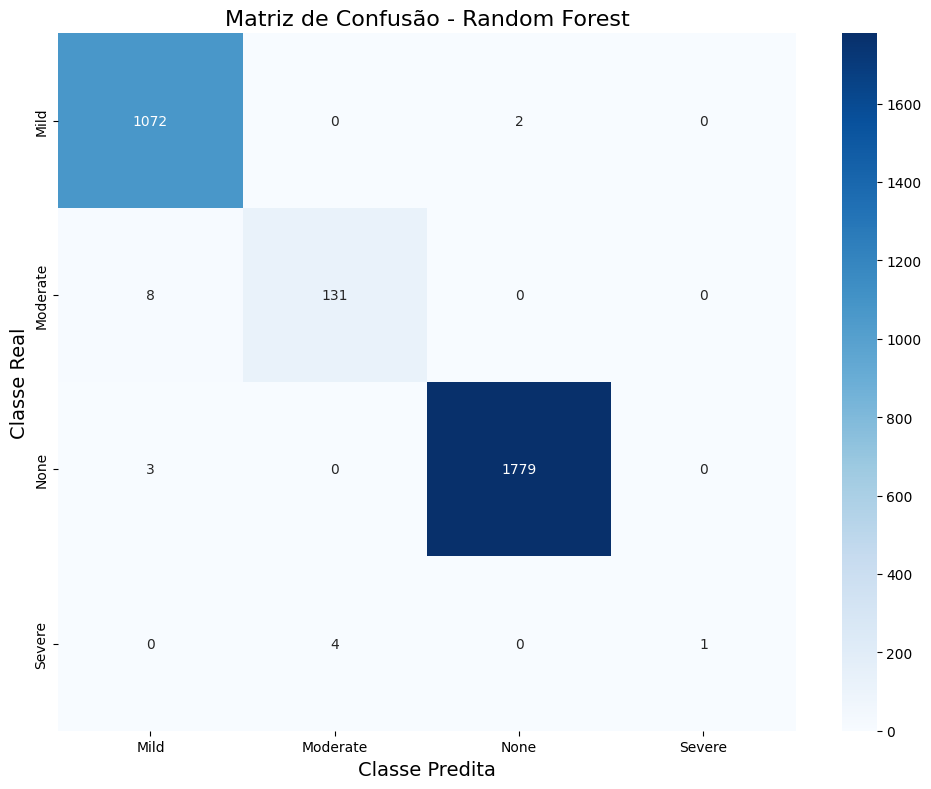


Features utilizadas (14): ['Age', 'Gender', 'Country_encoded', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Occupation_encoded', 'Smoking', 'Alcohol_Consumption']

Métricas de Desempenho:
Acurácia: 0.9943
Precisão: 0.9943
Recall: 0.9943
F1-Score: 0.9939

Validação Cruzada (10 folds):
Média: 0.9966 (+/- 0.0023)

------------------------------------------------------------


In [125]:
# Classificação com Random Forest (Todas as features)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest (Todas Features)")

plot_confusion_matrix(rf_results['confusion_matrix'], health_encoder.classes_, "Random Forest")
print_evaluation_results(rf_results, "Random Forest (Todas Features)", all_features)

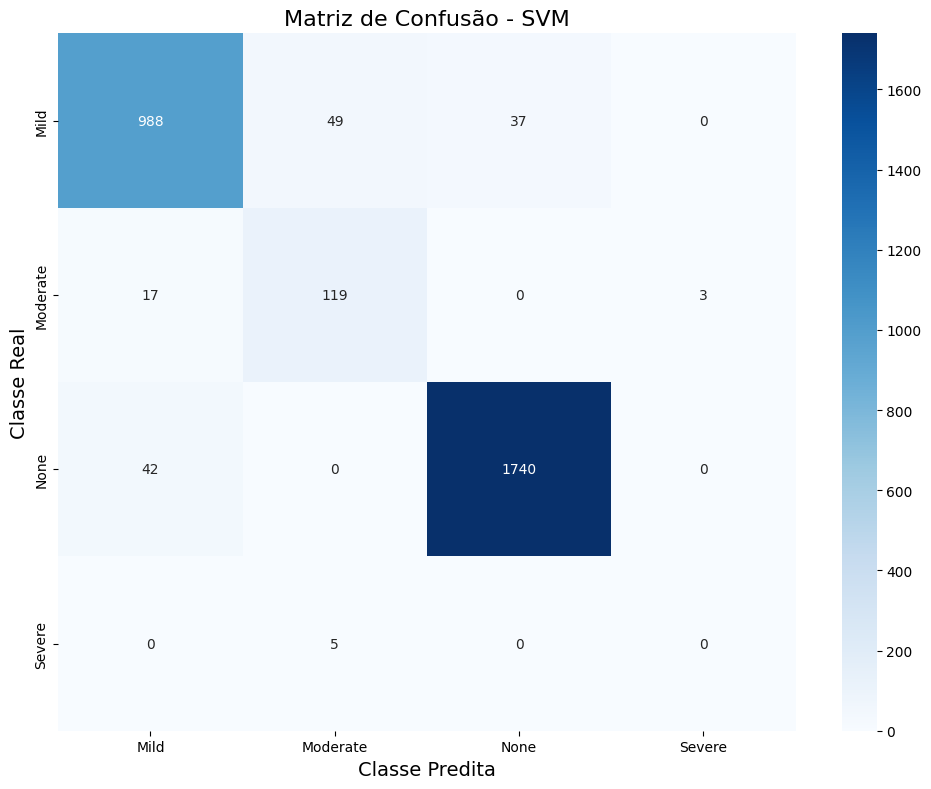


Features utilizadas (14): ['Age', 'Gender', 'Country_encoded', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Occupation_encoded', 'Smoking', 'Alcohol_Consumption']

Métricas de Desempenho:
Acurácia: 0.9490
Precisão: 0.9513
Recall: 0.9490
F1-Score: 0.9497

Validação Cruzada (10 folds):
Média: 0.9469 (+/- 0.0076)

------------------------------------------------------------


In [126]:
# Classificação com SVM (Todas as features)
svm_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    random_state=42,
    class_weight='balanced'
)

svm_results = evaluate_model(svm_model, X_train, X_test, y_train, y_test, "SVM (Todas Features)")

plot_confusion_matrix(svm_results['confusion_matrix'], health_encoder.classes_, "SVM")
print_evaluation_results(svm_results, "SVM (Todas Features)", all_features)

Importância das Features (Random Forest):
                Feature  Importance_RF
                    Age       0.279283
                    BMI       0.260402
            Sleep_Hours       0.107484
           Stress_Level       0.105110
          Sleep_Quality       0.084665
        Country_encoded       0.028434
            Caffeine_mg       0.026396
     Occupation_encoded       0.025875
Physical_Activity_Hours       0.025694
             Heart_Rate       0.025511
          Coffee_Intake       0.020097
                Smoking       0.004032
    Alcohol_Consumption       0.003695
                 Gender       0.003322

Top 3 features do Random Forest: ['Age', 'BMI', 'Sleep_Hours']


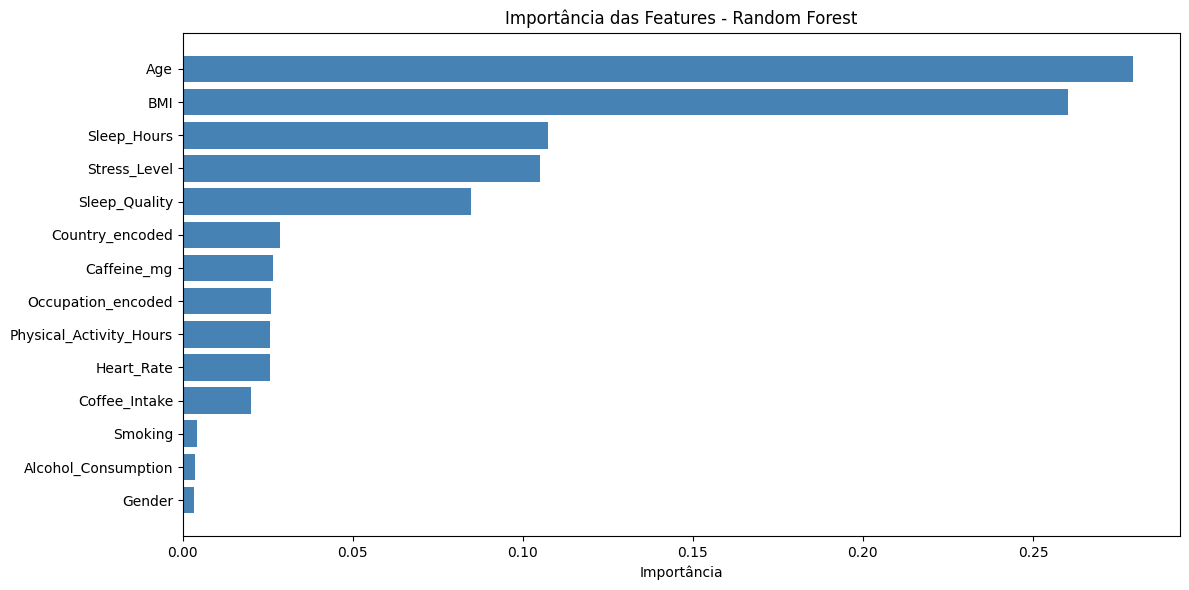

In [127]:
# Feature Importance para Random Forest

rf_importances = rf_model.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance_RF': rf_importances
}).sort_values('Importance_RF', ascending=False)

print("Importância das Features (Random Forest):")
print(rf_importance_df.to_string(index=False))

# Selecionar top 3 features do RF
rf_top_3_features = rf_importance_df.head(3)['Feature'].tolist()
print(f"\nTop 3 features do Random Forest: {rf_top_3_features}")

plt.figure(figsize=(12, 6))
plt.barh(range(len(rf_importance_df)), rf_importance_df['Importance_RF'], color='steelblue')
plt.yticks(range(len(rf_importance_df)), rf_importance_df['Feature'])
plt.xlabel('Importância')
plt.title('Importância das Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Importância das Features (SVM):
                Feature  Importance_SVM
           Stress_Level        0.203933
                    Age        0.136467
          Sleep_Quality        0.116200
                    BMI        0.082867
            Sleep_Hours        0.008800
            Caffeine_mg        0.003133
          Coffee_Intake        0.003033
     Occupation_encoded        0.001367
        Country_encoded        0.001300
Physical_Activity_Hours        0.001233
                Smoking        0.001133
             Heart_Rate        0.000833
    Alcohol_Consumption       -0.000400
                 Gender       -0.001233

Top 3 features do SVM: ['Stress_Level', 'Age', 'Sleep_Quality']


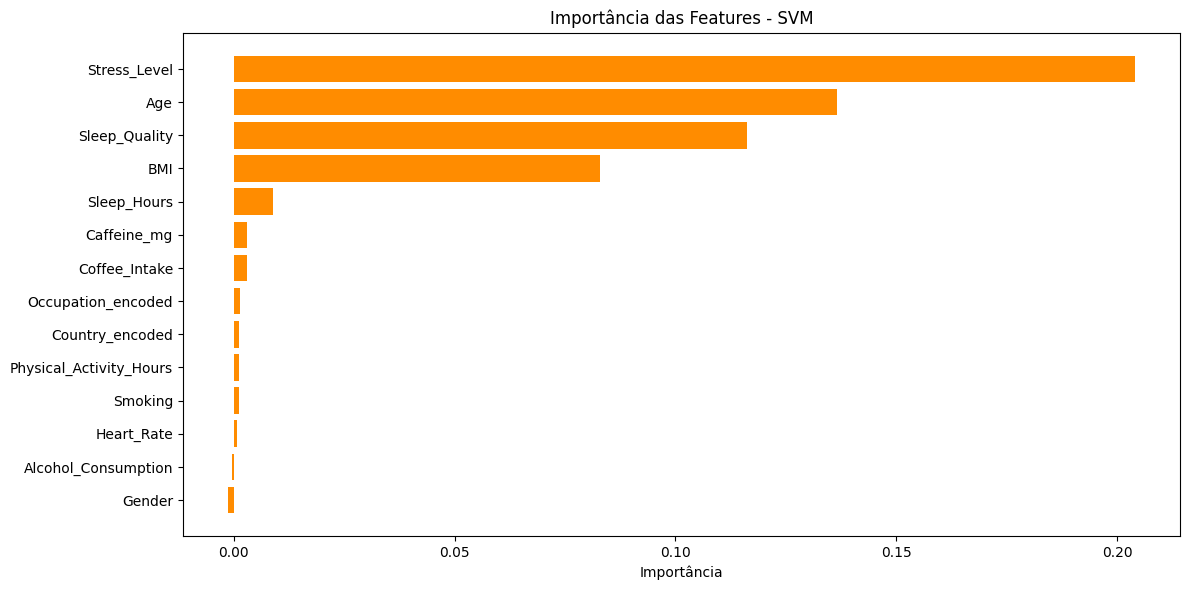

In [134]:
# Feature Importance para SVM

perm_importance = permutation_importance(
    svm_model, X_test, y_test, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

svm_importances = perm_importance.importances_mean

svm_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance_SVM': svm_importances
}).sort_values('Importance_SVM', ascending=False)

print("\nImportância das Features (SVM):")
print(svm_importance_df.to_string(index=False))

# Selecionar top 3 features do SVM
svm_top_3_features = svm_importance_df.head(3)['Feature'].tolist()
print(f"\nTop 3 features do SVM: {svm_top_3_features}")

plt.figure(figsize=(12, 6))
plt.barh(range(len(svm_importance_df)), svm_importance_df['Importance_SVM'], color='darkorange')
plt.yticks(range(len(svm_importance_df)), svm_importance_df['Feature'])
plt.xlabel('Importância')
plt.title('Importância das Features - SVM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [129]:
# Comparação das Feature Importances
print(f"\nResumo:")
print(f"Top 3 features do Random Forest: {rf_top_3_features}")
print(f"Top 3 features do SVM: {svm_top_3_features}")
print(f"Features em comum: {set(rf_top_3_features) & set(svm_top_3_features)}")


Resumo:
Top 3 features do Random Forest: ['Age', 'BMI', 'Sleep_Hours']
Top 3 features do SVM: ['Stress_Level', 'Age', 'Sleep_Quality']
Features em comum: {'Age'}


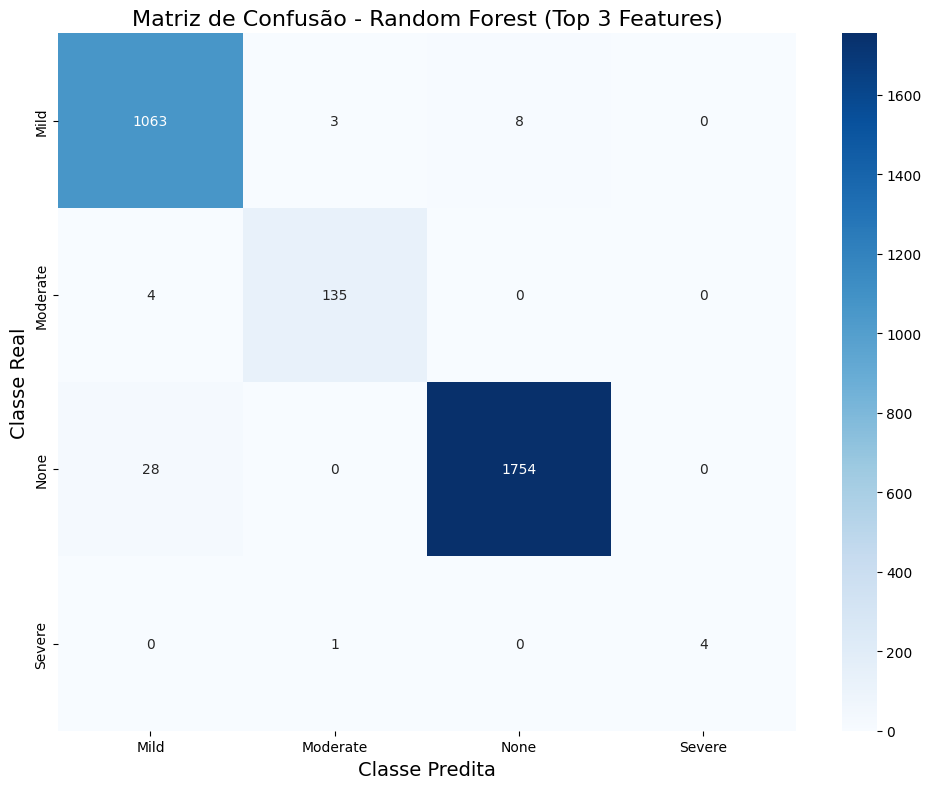


Features utilizadas (3): ['Age', 'BMI', 'Sleep_Hours']

Métricas de Desempenho:
Acurácia: 0.9853
Precisão: 0.9855
Recall: 0.9853
F1-Score: 0.9854

Validação Cruzada (10 folds):
Média: 0.9827 (+/- 0.0028)

------------------------------------------------------------


In [138]:
# Random Forest com Top 3 Features

X_train_rf_top3 = X_train[rf_top_3_features]
X_test_rf_top3 = X_test[rf_top_3_features]

rf_model_top3 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_results_top3 = evaluate_model(rf_model_top3, X_train_rf_top3, X_test_rf_top3, y_train, y_test, f"Random Forest (Top 3 Features: {rf_top_3_features})")

plot_confusion_matrix(rf_results_top3['confusion_matrix'], health_encoder.classes_, "Random Forest (Top 3 Features)")
print_evaluation_results(rf_results_top3, f"Random Forest com Top 3 Features", rf_top_3_features)

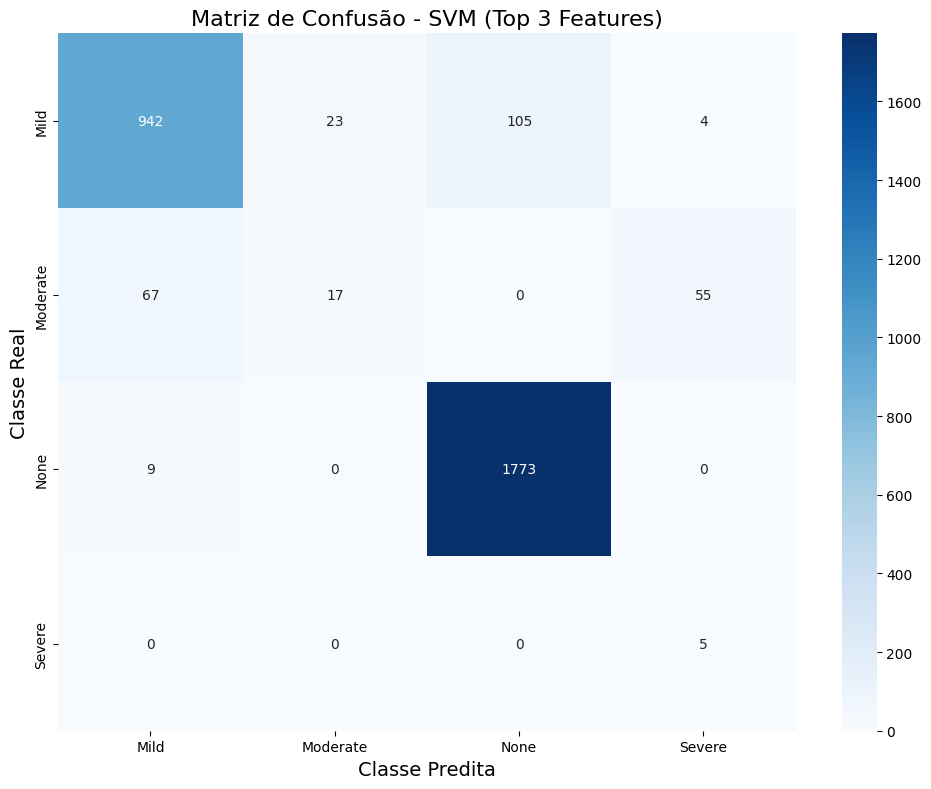


Features utilizadas (3): ['Stress_Level', 'Age', 'Sleep_Quality']

Métricas de Desempenho:
Acurácia: 0.9123
Precisão: 0.9119
Recall: 0.9123
F1-Score: 0.9069

Validação Cruzada (10 folds):
Média: 0.9077 (+/- 0.0106)

------------------------------------------------------------


In [137]:
# SVM com Top 3 Features

X_train_svm_top3 = X_train[svm_top_3_features]
X_test_svm_top3 = X_test[svm_top_3_features]

svm_model_top3 = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    random_state=42,
    class_weight='balanced'
)

svm_results_top3 = evaluate_model(svm_model_top3, X_train_svm_top3, X_test_svm_top3, y_train, y_test, f"SVM (Top 3 Features: {svm_top_3_features})")

plot_confusion_matrix(svm_results_top3['confusion_matrix'], health_encoder.classes_, "SVM (Top 3 Features)")
print_evaluation_results(svm_results_top3, f"SVM com Top 3 Features", svm_top_3_features)


Tabela de Resultados Completa:
     Modelo                                     Features_Usadas  Acurácia  F1-Score  N_Features
 RF - Todas                                          Todas (14)  0.994333  0.993868          14
 RF - Top 3             Top 3 RF: ['Age', 'BMI', 'Sleep_Hours']  0.985333  0.985350           3
SVM - Todas                                          Todas (14)  0.949000  0.949685          14
SVM - Top 3 Top 3 SVM: ['Stress_Level', 'Age', 'Sleep_Quality']  0.912333  0.906946           3


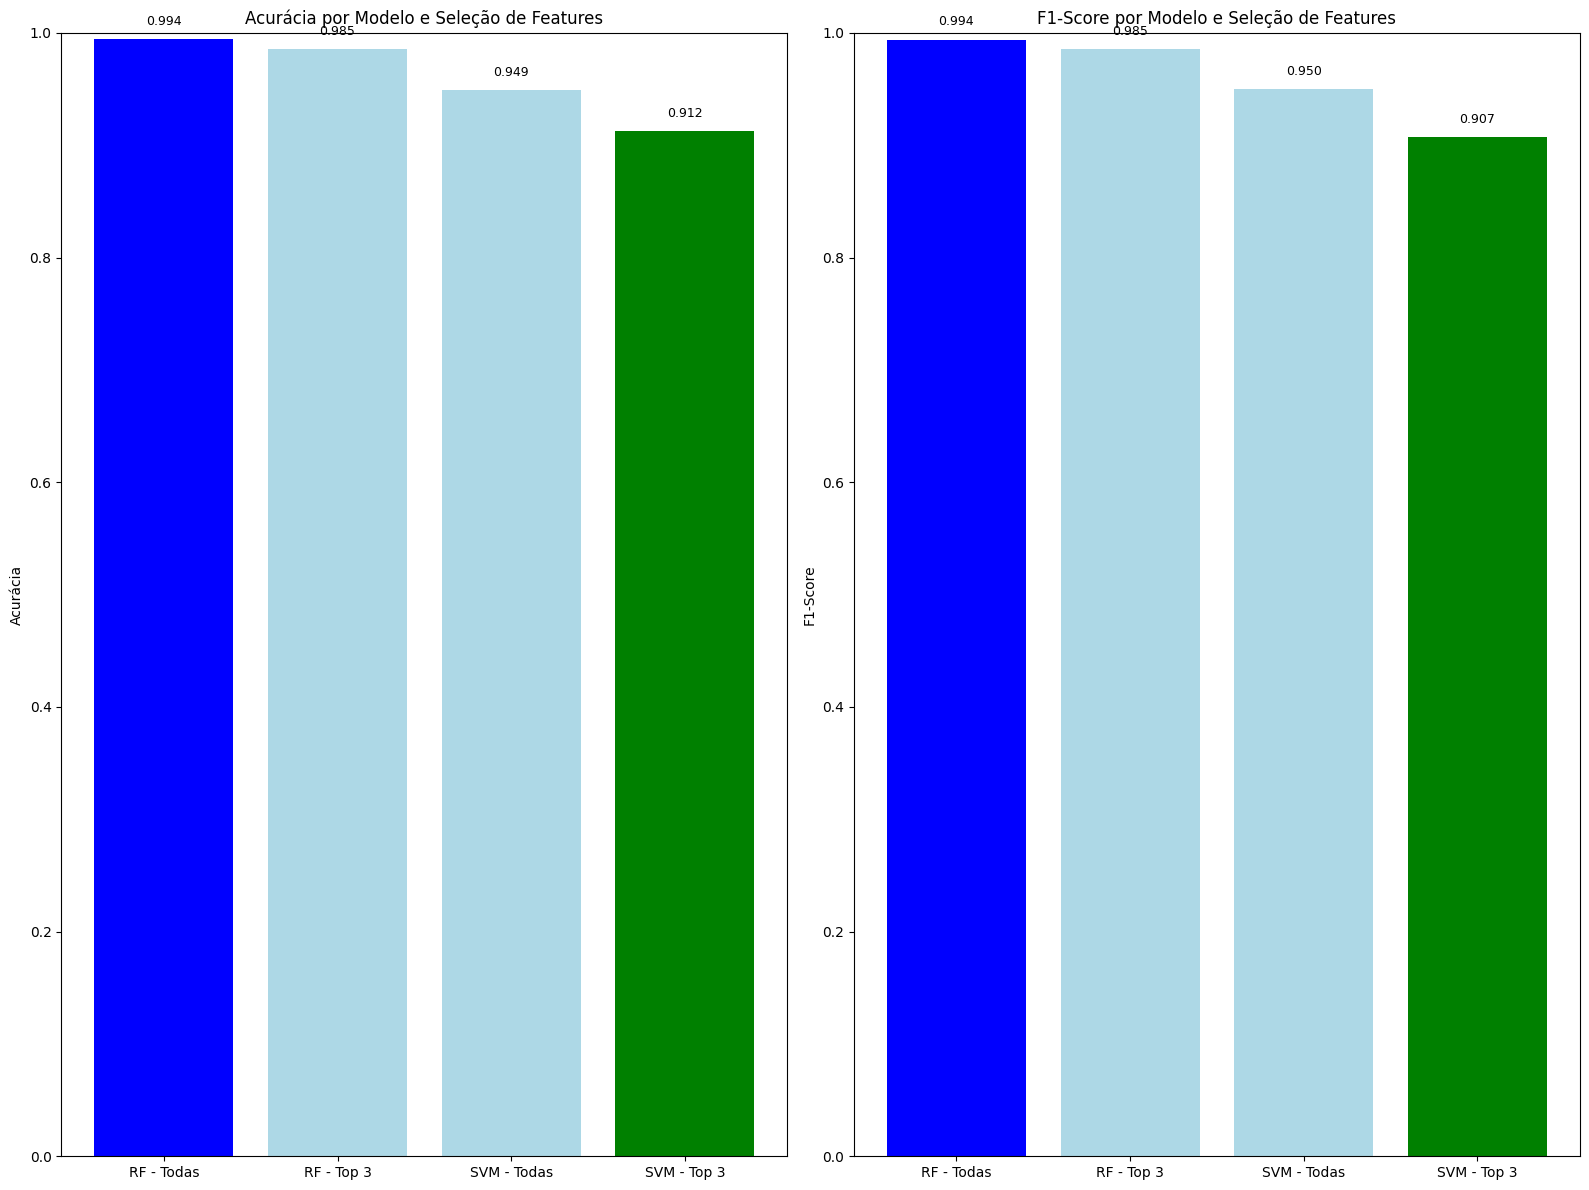

In [132]:
# Comparação final

all_results = pd.DataFrame({
    'Modelo': [
        'RF - Todas',
        'RF - Top 3',
        'SVM - Todas',
        'SVM - Top 3',
    ],
    'Features_Usadas': [
        f'Todas ({len(all_features)})',
        f'Top 3 RF: {rf_top_3_features}',
        f'Todas ({len(all_features)})',
        f'Top 3 SVM: {svm_top_3_features}',
    ],
    'Acurácia': [
        rf_results['accuracy'],
        rf_results_top3['accuracy'],
        svm_results['accuracy'],
        svm_results_top3['accuracy'],
    ],
    'F1-Score': [
        rf_results['f1'],
        rf_results_top3['f1'],
        svm_results['f1'],
        svm_results_top3['f1'],
    ],
    'N_Features': [
        len(all_features),
        3,
        len(all_features),
        3,
    ]
})

print("\nTabela de Resultados Completa:")
print(all_results.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 12))

colors = ['blue', 'lightblue', 'lightblue', 'green', 'lightgreen', 'lightgreen']
bars1 = axes[0].bar(all_results['Modelo'], all_results['Acurácia'], color=colors)
axes[0].set_title('Acurácia por Modelo e Seleção de Features')
axes[0].set_ylabel('Acurácia')
axes[0].tick_params(axis='x', rotation=0)
axes[0].set_ylim([0, 1])

for bar, acc in zip(bars1, all_results['Acurácia']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

bars2 = axes[1].bar(all_results['Modelo'], all_results['F1-Score'], color=colors)
axes[1].set_title('F1-Score por Modelo e Seleção de Features')
axes[1].set_ylabel('F1-Score')
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_ylim([0, 1])

for bar, f1 in zip(bars2, all_results['F1-Score']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

rf_indices = [0, 1]
svm_indices = [2, 3]

plt.tight_layout()
plt.show()